# 저조도 이미지 향상을 위한 Zero-DCE

**Author:** [Soumik Rakshit](http://github.com/soumik12345)<br>
**Date created:** 2021/09/18<br>
**Last modified:** 2021/09/19<br>
**Description:** 저조도 이미지 향상을 위한 Zero-Reference Deep Curve Estimation 구현.

## 소개

**Zero-Reference Deep Curve Estimation** 또는 **Zero-DCE**는 이미지별 추정 작업으로 저조도 이미지 향상을 공식화합니다.
[*음조 곡선*](https://en.wikipedia.org/wiki/Curve_(tonality)) 심층 신경망.
이 예에서 우리는 주어진 이미지의 동적 범위 조정을 위해 픽셀 단위 및 고차 톤 곡선을 추정하기 위해 경량 심층 네트워크 **DCE-Net**을 훈련합니다.

Zero-DCE는 저조도 이미지를 입력으로 사용하고 출력으로 고차 톤 곡선을 생성합니다.
이 곡선은 향상된 이미지를 얻기 위해 입력의 동적 범위에 대한 픽셀 단위 조정에 사용됩니다. 곡선 추정 프로세스는 향상된 이미지의 범위를 유지하고 인접 픽셀의 대비를 유지하는 방식으로 수행됩니다. 이 곡선 추정은 사용자가 이미지의 색조 범위 전체에서 포인트를 조정할 수 있는 Adobe Photoshop과 같은 사진 편집 소프트웨어에서 사용되는 곡선 조정에서 영감을 받았습니다.

Zero-DCE는 참조 이미지와 관련하여 완화된 가정 때문에 매력적입니다.
훈련 중에 입력/출력 이미지 쌍이 필요하지 않습니다.
이것은 암시적으로 향상 품질을 측정하고 네트워크 교육을 안내하는 신중하게 공식화된 비참조 손실 함수 세트를 통해 달성됩니다.

### 참조

- [Zero-Reference Deep Curve Estimation for Low-Light Image Enhancement](https://arxiv.org/pdf/2001.06826.pdf)
- [Curves adjustment in Adobe Photoshop](https://helpx.adobe.com/photoshop/using/curves-adjustment.html)

## LOLDataset 다운로드

**LoL Dataset**은 저조도 이미지 향상을 위해 생성되었습니다. 훈련용 이미지 485개와 테스트용 이미지 15개를 제공합니다. 데이터 세트의 각 이미지 쌍은 저조도 입력 이미지와 해당하는 잘 노출된 참조 이미지로 구성됩니다.

In [12]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!gdown https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
!unzip -q lol_dataset.zip

## TensorFlow 데이터세트 만들기

LoL Dataset 훈련 세트에서 300개의 저조도 이미지를 훈련에 사용하고 나머지 185개의 저조도 이미지를 검증에 사용합니다. 훈련과 검증 모두에 사용할 이미지 크기를 `256 x 256`으로 조정합니다. DCE-Net을 훈련하기 위해 해당하는 향상된 이미지가 필요하지 않습니다.

In [14]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400


def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image


def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))


train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <BatchDataset shapes: (16, 256, 256, 3), types: tf.float32>
Validation Dataset: <BatchDataset shapes: (16, 256, 256, 3), types: tf.float32>


## Zero-DCE 프레임워크

DCE-Net의 목표는 입력 이미지가 주어지면 최적의 조명 향상 곡선(LE-커브) 세트를 추정하는 것입니다. 그런 다음 프레임워크는 곡선을 반복적으로 적용하여 향상된 최종 이미지를 얻음으로써 입력 RGB 채널의 모든 픽셀을 매핑합니다.

### 조명 향상 곡선 이해

조명 향상 곡선은 저조도 이미지를 향상된 버전에 자동으로 매핑할 수 있는 일종의 곡선입니다. 여기서 자체 적응 곡선 매개변수는 입력 이미지에만 의존합니다.
이러한 곡선을 설계할 때 세 가지 목표를 고려해야 합니다.

- 오버플로 절단으로 인한 정보 손실을 방지하기 위해 강화된 이미지의 각 픽셀 값은 정규화된 범위 '[0,1]'에 있어야 합니다.
- 인접 픽셀 간의 대비를 유지하려면 단조로워야 합니다.
- 이 곡선의 모양은 가능한 한 단순해야 하며 곡선은 역전파(backpropagation)가 가능하도록 미분 가능해야 합니다.

조명 강화 곡선은 조명 채널에만 적용되는 것이 아니라 3개의 RGB 채널에 별도로 적용됩니다. 3채널 조정으로 고유한 색상을 더 잘 보존하고
과포화의 위험.

![](https://li-chongyi.github.io/Zero-DCE_files/framework.png)

### DCE-넷

DCE-Net은 입력 이미지와 가장 적합한 곡선 매개변수 맵 간의 매핑을 학습하는 경량 심층 신경망입니다. DCE-Net에 대한 입력은 저조도 이미지이고 출력은 대응하는 픽셀 단위 곡선 매개변수 맵 세트입니다.
고차 곡선. 대칭 연결이 있는 7개의 컨볼루션 레이어로 구성된 일반 CNN입니다. 각 레이어는 크기가 3×3인 32개의 컨볼루션 커널과 보폭 1과 ReLU 활성화 함수로 구성됩니다. 마지막 컨볼루션 레이어 다음에는
Tanh 활성화 함수는 8회 반복에 대해 24개의 매개변수 맵을 생성합니다. 여기서 각 반복에는 3개의 채널에 대해 3개의 곡선 매개변수 맵이 필요합니다.

![](https://i.imgur.com/HtIg34W.png)

In [15]:

def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"  
    )(input_img)                                                           # (16,256,256,32)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)                                                               # (16,256,256,32)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)                                                               # (16,256,256,32)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)                                                               # (16,256,256,32)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])                 # (16,256,256,64) 
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)                                                            # (16,256,256,32) 
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])                 # (16,256,256,64) 
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)                                                            # (16,256,256,32) 
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])                 # (16,256,256,64) 
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )                                                                      # (16,256,256,8) 
    return keras.Model(inputs=input_img, outputs=x_r)


## 손실 함수

DCE-Net에서 제로 참조 학습을 활성화하기 위해 향상된 이미지의 품질을 평가할 수 있는 미분 가능한 제로 참조 손실 세트를 사용합니다.

### 색상 불변성 손실

*색상 불변성 손실*은 향상된 이미지의 잠재적인 색상 편차를 수정하는 데 사용됩니다.

In [16]:

def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))


### 노출 손실

노출 부족/과다 영역을 억제하기 위해 *노출 제어 손실*을 사용합니다.
특정 지역의 평균 강도 값과 미리 설정된 노출도 수준('0.6'으로 설정) 사이의 거리를 측정합니다.

In [17]:

def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))


### 조명 평활도 손실

인접 픽셀 간의 단조성 관계를 유지하기 위해 *조명 평활도 손실*이 각 곡선 매개변수 맵에 추가됩니다.

In [19]:

def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size


### 공간 일관성 손실

*공간 일관성 손실*은 입력 이미지와 향상된 버전에서 인접 영역 간의 대비를 유지하여 향상된 이미지의 공간적 일관성을 촉진합니다.

In [7]:

class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], 
              [[-1, 1, 0]], 
              [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], 
              [[0, 1, -1]], 
              [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], 
              [[0, 1, 0]], 
              [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], 
              [[0, 1, 0]], 
              [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down


### 깊은 곡선 추정 모델

Keras 하위 클래스 모델로 Zero-DCE 프레임워크를 구현합니다.

In [20]:

class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]    # (1,256,256,24)  [[R,G,B],[R,G,B],...]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


## 훈련

Epoch 1/100
25/25 [==============================] - 103s 4s/step - total_loss: 5.6997 - illumination_smoothness_loss: 2.7786 - spatial_constancy_loss: 5.1508e-05 - color_constancy_loss: 0.0034 - exposure_loss: 2.9177 - val_total_loss: 4.8795 - val_illumination_smoothness_loss: 1.8873 - val_spatial_constancy_loss: 4.3771e-05 - val_color_constancy_loss: 4.1313e-04 - val_exposure_loss: 2.9918
Epoch 2/100
25/25 [==============================] - 105s 4s/step - total_loss: 4.6937 - illumination_smoothness_loss: 1.7842 - spatial_constancy_loss: 7.2074e-05 - color_constancy_loss: 0.0032 - exposure_loss: 2.9062 - val_total_loss: 4.1977 - val_illumination_smoothness_loss: 1.2149 - val_spatial_constancy_loss: 6.2462e-05 - val_color_constancy_loss: 4.0031e-04 - val_exposure_loss: 2.9824
Epoch 3/100
25/25 [==============================] - 107s 4s/step - total_loss: 4.1452 - illumination_smoothness_loss: 1.2456 - spatial_constancy_loss: 9.2245e-05 - color_constancy_loss: 0.0031 - exposure_loss: 2

Epoch 22/100
25/25 [==============================] - 111s 4s/step - total_loss: 1.2829 - illumination_smoothness_loss: 0.1891 - spatial_constancy_loss: 0.2584 - color_constancy_loss: 0.0700 - exposure_loss: 0.7655 - val_total_loss: 1.5332 - val_illumination_smoothness_loss: 0.1710 - val_spatial_constancy_loss: 0.2291 - val_color_constancy_loss: 0.0356 - val_exposure_loss: 1.0974
Epoch 23/100
25/25 [==============================] - 111s 4s/step - total_loss: 1.2628 - illumination_smoothness_loss: 0.1746 - spatial_constancy_loss: 0.2683 - color_constancy_loss: 0.0725 - exposure_loss: 0.7474 - val_total_loss: 1.5227 - val_illumination_smoothness_loss: 0.1644 - val_spatial_constancy_loss: 0.2341 - val_color_constancy_loss: 0.0365 - val_exposure_loss: 1.0877
Epoch 24/100
25/25 [==============================] - 112s 4s/step - total_loss: 1.2488 - illumination_smoothness_loss: 0.1618 - spatial_constancy_loss: 0.2689 - color_constancy_loss: 0.0722 - exposure_loss: 0.7459 - val_total_loss: 1

25/25 [==============================] - 112s 4s/step - total_loss: 1.1105 - illumination_smoothness_loss: 0.0302 - spatial_constancy_loss: 0.2945 - color_constancy_loss: 0.0771 - exposure_loss: 0.7087 - val_total_loss: 1.3743 - val_illumination_smoothness_loss: 0.0356 - val_spatial_constancy_loss: 0.2590 - val_color_constancy_loss: 0.0416 - val_exposure_loss: 1.0382
Epoch 65/100
25/25 [==============================] - 112s 4s/step - total_loss: 1.1093 - illumination_smoothness_loss: 0.0290 - spatial_constancy_loss: 0.2954 - color_constancy_loss: 0.0772 - exposure_loss: 0.7076 - val_total_loss: 1.3726 - val_illumination_smoothness_loss: 0.0337 - val_spatial_constancy_loss: 0.2581 - val_color_constancy_loss: 0.0411 - val_exposure_loss: 1.0397
Epoch 66/100
25/25 [==============================] - 112s 4s/step - total_loss: 1.1088 - illumination_smoothness_loss: 0.0285 - spatial_constancy_loss: 0.2948 - color_constancy_loss: 0.0774 - exposure_loss: 0.7082 - val_total_loss: 1.3736 - val_i

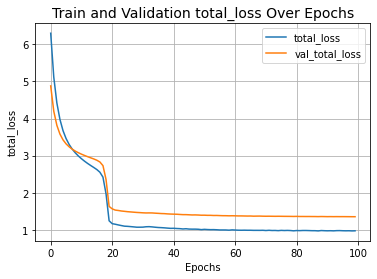

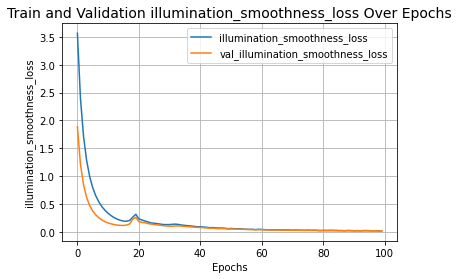

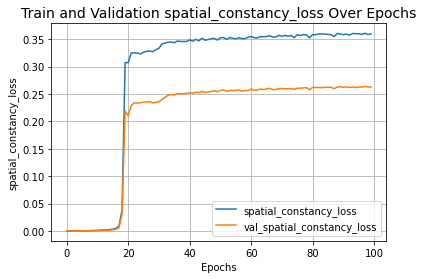

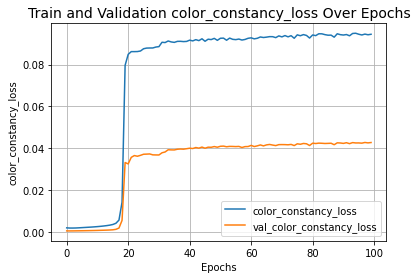

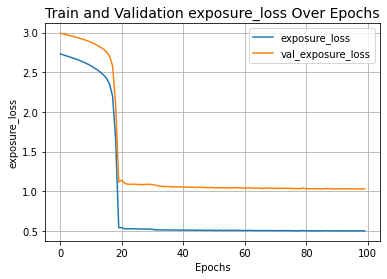

In [9]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=100)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

## 추론

In [10]:

def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image


### 테스트 이미지에 대한 추론

MIRNet에 의해 강화된 LOLDataset의 테스트 이미지와 `PIL.ImageOps.autocontrast()' 함수를 통해 강화된 이미지를 비교합니다.

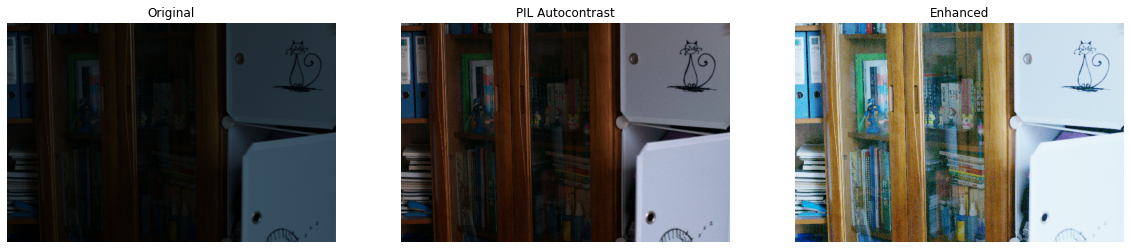

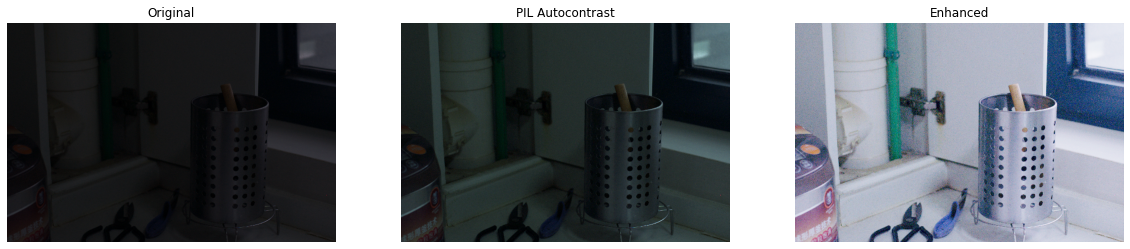

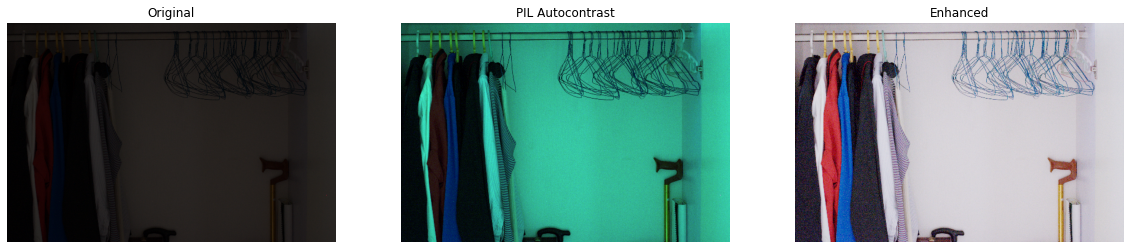

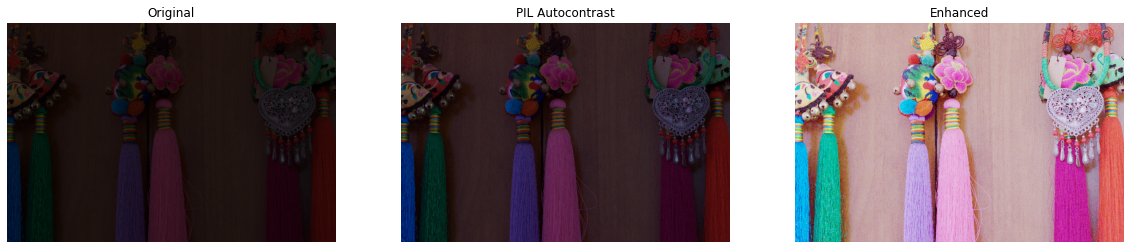

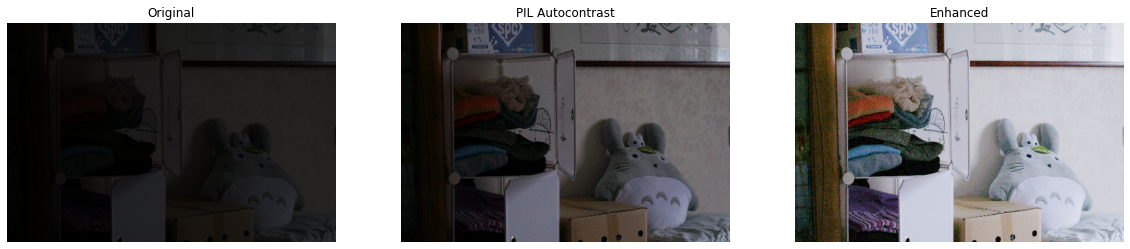

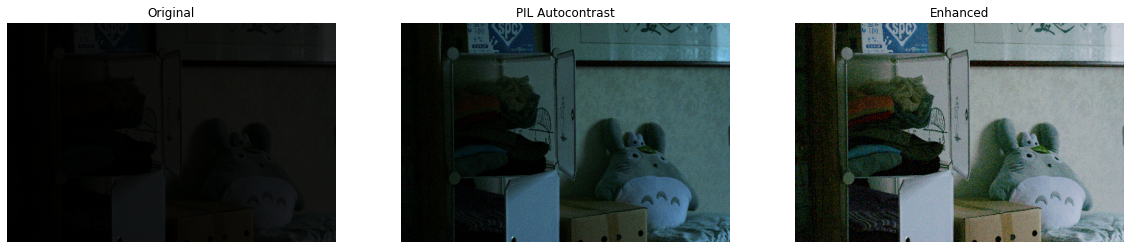

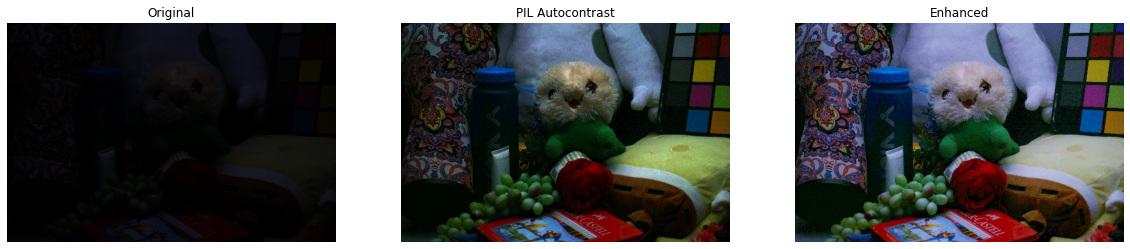

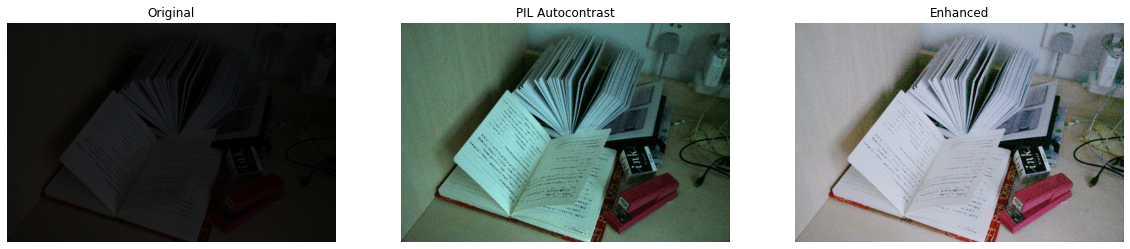

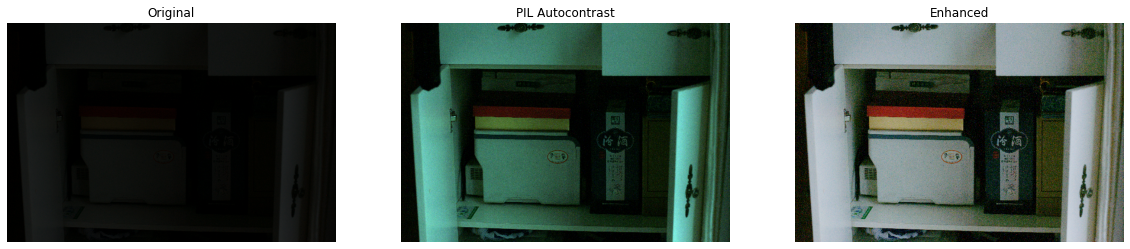

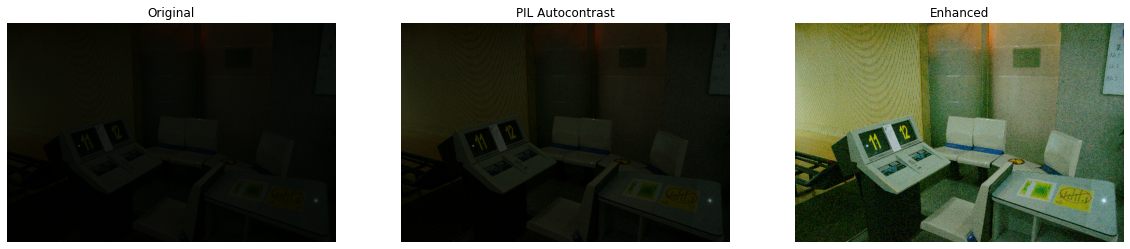

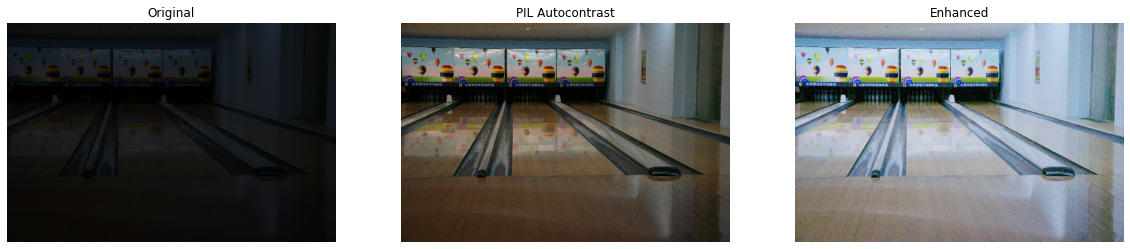

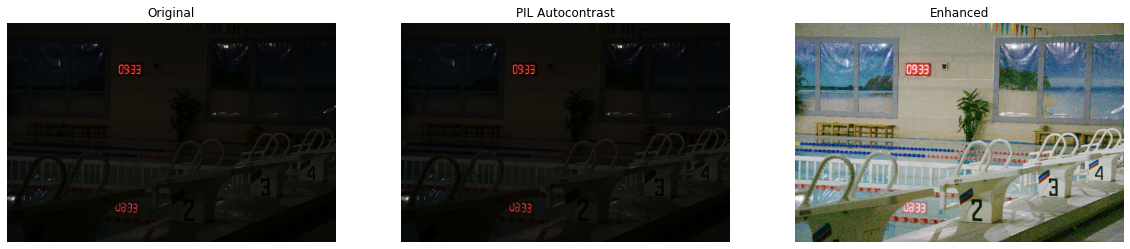

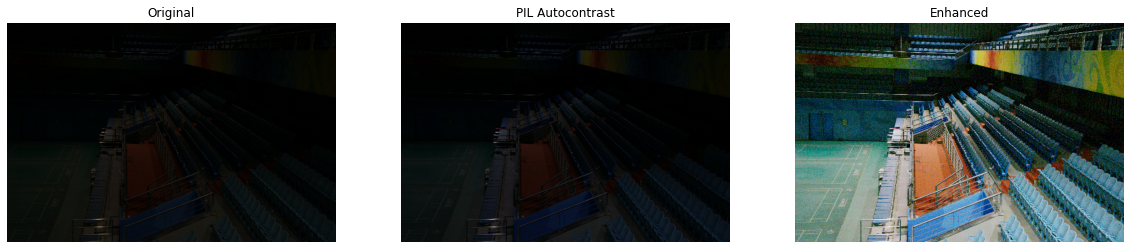

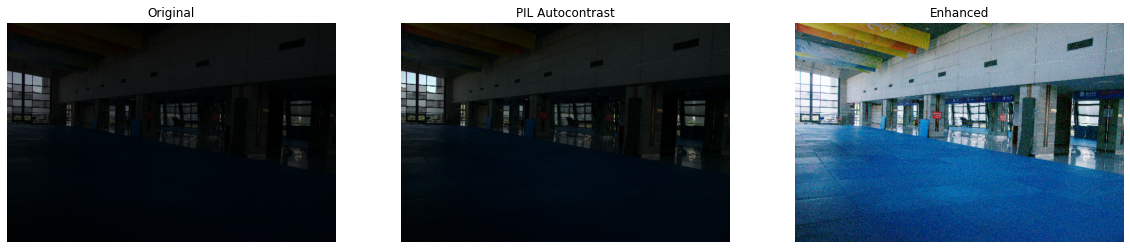

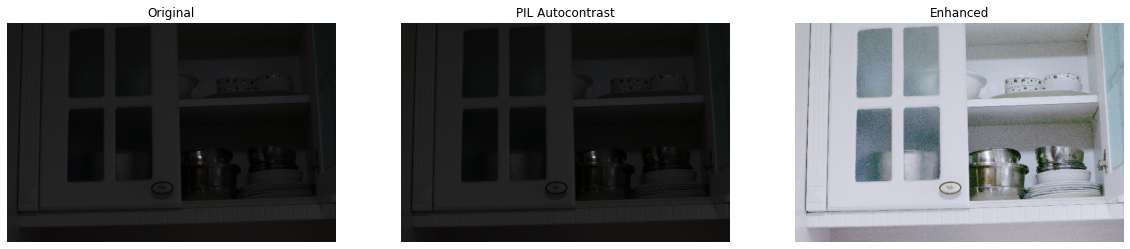

In [11]:
for val_image_file in test_low_light_images:
    original_image = Image.open(val_image_file)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "Enhanced"],
        (20, 12),
    )